# Gradient-Regularized Scalar Fluid: Linear Growth Notebook

This notebook provides a self-contained testbench for the linear growth equation

δ̈_k + 2H δ̇_k + ( cₛ²(a) k² / a² + κ_eff k⁴ / a⁴ − 4π G ρ̄(a) ) δ_k = 0.

It includes background evolution functions, a configurable spinodal window in which cₛ²(a) may become negative, numerical integration of the growth equation in ln a, and basic visualizations of growth behavior and stability bands.

For many exploratory tests it is convenient to set H₀ = 1 and G = 1, rendering the system dimensionless and simplifying numerical experimentation.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def logspace(a, b, n=200):
    return np.exp(np.linspace(np.log(a), np.log(b), n))


## 1. Background cosmology H(a) and ρ̄(a)

We model a spatially flat ΛCDM background:

H(a) = H₀ √( Ω_r a⁻⁴ + Ω_m a⁻³ + Ω_Λ ).

The clustered matter density evolves as

ρ̄_m(a) = ρ_{m0} a⁻³, with ρ_{m0} = (3 H₀² / 8π G) Ω_m.


In [2]:
# Background parameters (dimensionless defaults)
H0 = 1.0
G  = 1.0

Omega_r = 0.0
Omega_m = 1.0
Omega_L = 0.0

def H_of_a(a):
    return H0*np.sqrt(Omega_r*a**(-4) + Omega_m*a**(-3) + Omega_L)

def rho_m_of_a(a):
    rho_m0 = 3*H0**2*Omega_m/(8*np.pi*G)
    return rho_m0*a**(-3)

def four_pi_G_rho(a):
    return 4*np.pi*G*rho_m_of_a(a)


## 2. Model inputs: cₛ²(a) with a finite spinodal interval and κ_eff

We implement cₛ²(a) as a baseline value together with a finite interval in scale factor where it becomes negative, representing a controlled spinodal window. Outside this interval the sound speed remains positive, restoring stabilizing pressure support. This piecewise prescription may be replaced by any smooth functional form suited to the physical scenario under study.



In [3]:
# Spinodal window for c_s^2(a)
a_on  = 0.20
a_off = 0.40

cs2_outside = 0.0
cs2_inside  = -1e-4

def cs2_of_a(a):
    a = np.asarray(a)
    cs2 = np.full_like(a, cs2_outside, dtype=float)
    mask = (a > a_on) & (a < a_off)
    cs2[mask] = cs2_inside
    return cs2

# Gradient regulator
kappa_eff = 1e-6


## 3. Growth equation in x = ln a

Using the relation d/dt = H(a) d/dx, the linear growth equation may be written in terms of x = ln a as

δ″ + ( 2 + d ln H / dx ) δ′ + (1 / H²) ( cₛ² k² / a² + κ_eff k⁴ / a⁴ − 4π G ρ̄ ) δ = 0,

where primes denote derivatives with respect to x.



In [4]:
def dlnH_dx(a, eps=1e-6):
    x = np.log(a)
    a1 = np.exp(x - eps)
    a2 = np.exp(x + eps)
    return (np.log(H_of_a(a2)) - np.log(H_of_a(a1))) / (2*eps)

def omega2_term(a, k):
    return cs2_of_a(a)*(k**2)/(a**2) + kappa_eff*(k**4)/(a**4) - four_pi_G_rho(a)

def Q_of_a_k(a, k):
    return omega2_term(a, k)/(H_of_a(a)**2)

def integrate_growth_ln_a(k, a_i=1e-3, a_f=1.0, n_steps=800, delta_i=None, delta_prime_i=None):
    x_i = np.log(a_i)
    x_f = np.log(a_f)
    xs = np.linspace(x_i, x_f, n_steps)
    dx = xs[1]-xs[0]
    a_grid = np.exp(xs)

    # Growing-mode-like IC in EdS: delta ~ a => delta' = delta in x=ln a
    if delta_i is None:
        delta_i = a_i
    if delta_prime_i is None:
        delta_prime_i = delta_i

    y = np.zeros((n_steps, 2), dtype=float)
    y[0,0] = delta_i
    y[0,1] = delta_prime_i

    def f(x, yvec):
        a = np.exp(x)
        d, dp = yvec
        A = 2.0 + dlnH_dx(a)
        Q = Q_of_a_k(a, k)
        return np.array([dp, -A*dp - Q*d], dtype=float)

    for i in range(n_steps-1):
        x = xs[i]
        yi = y[i]
        k1 = f(x, yi)
        k2 = f(x + 0.5*dx, yi + 0.5*dx*k1)
        k3 = f(x + 0.5*dx, yi + 0.5*dx*k2)
        k4 = f(x + dx, yi + dx*k3)
        y[i+1] = yi + (dx/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return a_grid, y[:,0], y[:,1]



## 4. Sanity check: EdS dust limit

Set Ω_m = 1, Ω_Λ = 0, cₛ² = 0, and κ_eff = 0. In this Einstein–de Sitter dust limit, the growing solution satisfies D(a) ∝ a.


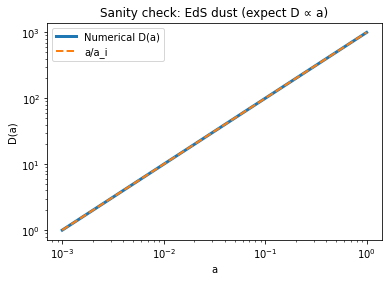

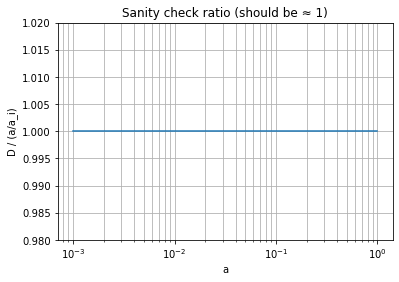

In [6]:
def run_sanity_test():
    global kappa_eff, cs2_inside, cs2_outside, Omega_m, Omega_L, Omega_r
    old = (kappa_eff, cs2_inside, cs2_outside, Omega_m, Omega_L, Omega_r)

    Omega_m, Omega_L, Omega_r = 1.0, 0.0, 0.0
    kappa_eff = 0.0
    cs2_outside = 0.0
    cs2_inside = 0.0

    k = 0.1
    a, d, dp = integrate_growth_ln_a(k, a_i=1e-3, a_f=1.0, n_steps=700)
    D = d / d[0]
    D_expected = a / a[0]

    plt.figure()
    plt.plot(a, D, label="Numerical D(a)", linewidth=3, zorder=1)
    plt.plot(a, D_expected, "--", label="a/a_i", linewidth=2, zorder=2)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("a")
    plt.ylabel("D(a)")
    plt.title("Sanity check: EdS dust (expect D ∝ a)")
    plt.legend()
    plt.show()

    # Diagnostic: ratio should be ~1
    ratio = D / D_expected
    plt.figure()
    plt.plot(a, ratio)
    plt.xscale("log")
    plt.xlabel("a")
    plt.ylabel("D / (a/a_i)")
    plt.title("Sanity check ratio (should be ≈ 1)")
    plt.ylim(0.98, 1.02)  # tighten if it's even closer
    plt.grid(True, which="both")
    plt.show()

    (kappa_eff, cs2_inside, cs2_outside, Omega_m, Omega_L, Omega_r) = old

run_sanity_test()


## 5. Dispersion and stability band diagnostics

For fixed a, the instantaneous dispersion structure is

ω²(k, a) = cₛ²(a) k² / a² + κ_eff k⁴ / a⁴ − 4π G ρ̄(a).

This section visualizes ω² and highlights unstable regions where ω² < 0.


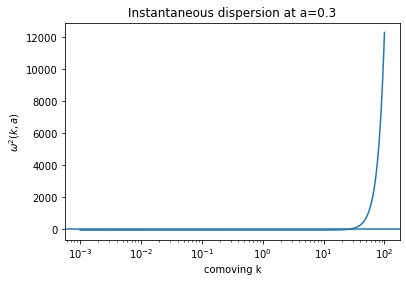

In [7]:
def omega2(a, k):
    return omega2_term(a, k)

def plot_dispersion(a=0.3, kmin=1e-3, kmax=1e2, n=500):
    ks = logspace(kmin, kmax, n)
    w2 = omega2(a, ks)

    plt.figure()
    plt.plot(ks, w2)
    plt.xscale("log")
    plt.xlabel("comoving k")
    plt.ylabel(r"$\omega^2(k,a)$")
    plt.title(f"Instantaneous dispersion at a={a}")
    plt.axhline(0.0)
    plt.show()

plot_dispersion(a=0.3)


## 6. Integrate growth for a grid of k and visualize D(k, a)

We integrate the growth equation over a range of wavenumbers k and compute the normalized growth factor

D(k, a) = δ_k(a) / δ_k(a_i),

which measures the amplification of each mode relative to its initial amplitude. Visualizing D(k, a) reveals the scale dependence of growth and highlights any instability bands or suppression regimes.


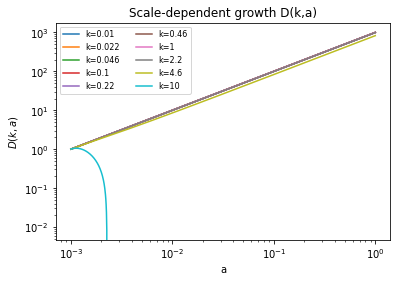

In [8]:
def run_grid(ks, a_i=1e-3, a_f=1.0, n_steps=900):
    out = {}
    for k in ks:
        a, d, dp = integrate_growth_ln_a(k, a_i=a_i, a_f=a_f, n_steps=n_steps)
        out[k] = (a, d, dp)
    return out

ks = logspace(1e-2, 1e1, 10)
grid = run_grid(ks)

plt.figure()
for k, (a, d, dp) in grid.items():
    D = d/d[0]
    plt.plot(a, D, label=f"k={k:.2g}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("a")
plt.ylabel(r"$D(k,a)$")
plt.title("Scale-dependent growth D(k,a)")
plt.legend(ncol=2, fontsize=8)
plt.show()


## 7. Transfer-like ratio relative to EdS dust growth

Define

R(k) = [ δ_k(a₀) / δ_k(a_i) ] / ( a₀ / a_i ),

which equals unity in the Einstein–de Sitter dust limit. This ratio isolates late-time scale dependence introduced by the regulated sector.


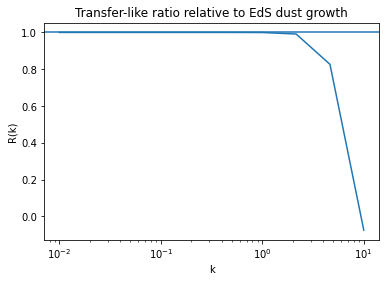

In [9]:
def transfer_like_ratio(k, a_i=1e-3, a_0=1.0, n_steps=900):
    a, d, dp = integrate_growth_ln_a(k, a_i=a_i, a_f=a_0, n_steps=n_steps)
    D = d[-1]/d[0]
    D_std = a_0/a_i
    return D/D_std

ratios = np.array([transfer_like_ratio(k) for k in ks])

plt.figure()
plt.plot(ks, ratios)
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("R(k)")
plt.title("Transfer-like ratio relative to EdS dust growth")
plt.axhline(1.0)
plt.show()



## 8. Parameter sweeps

Sweep over κ_eff (and, if desired, the spinodal-window magnitude in cₛ²(a)) and compare the resulting R(k) curves. This reveals how gradient regularization and transient negative-pressure intervals reshape the instability band structure and the net scale-dependent amplification.


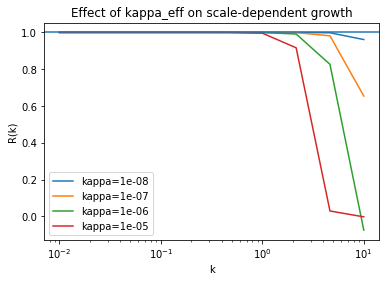

In [10]:
def sweep_kappa(kappas, ks, cs2_in=None):
    global kappa_eff, cs2_inside
    old_kappa = kappa_eff
    old_cs2in = cs2_inside
    if cs2_in is not None:
        cs2_inside = cs2_in

    results = {}
    for kap in kappas:
        kappa_eff = kap
        results[kap] = np.array([transfer_like_ratio(k) for k in ks])

    kappa_eff = old_kappa
    cs2_inside = old_cs2in
    return results

kappas = [1e-8, 1e-7, 1e-6, 1e-5]
sres = sweep_kappa(kappas, ks)

plt.figure()
for kap, rr in sres.items():
    plt.plot(ks, rr, label=f"kappa={kap:g}")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("R(k)")
plt.title("Effect of kappa_eff on scale-dependent growth")
plt.axhline(1.0)
plt.legend()
plt.show()


## 9. Notes for extension

To extend the present notebook beyond its diagnostic scope, the boxcar spinodal window for cₛ²(a) may be replaced with a smooth, thermodynamically consistent model derived from an explicit equation of state ε(n) and pressure function p(n). Such a construction allows the effective sound speed and compressibility to arise from microscopic assumptions rather than prescribed intervals.

Initial conditions may also be matched across radiation–matter equality by specifying δ_k and its logarithmic derivative in the radiation era and evolving continuously through the transition. This produces growth histories that are consistent with early-time acoustic evolution and avoids artificial mode normalization.

For observationally faithful predictions, the perturbation sector can be coupled to a Boltzmann solver to propagate the regulated dynamics into a full transfer function. In this setting, the gradient-regularization term modifies the evolution of modes prior to horizon entry and imprints scale-dependent features that can be compared with large-scale structure and cosmic microwave background observables.
